In [8]:
import bs4
import requests
import json
import time
import pandas as pd
from random import shuffle
from thefuzz import process, fuzz
from modules.CountMinSketch.count_min_sketch2 import CountMinSketch2
from modules.BloomFilter.bloom_filter2 import BloomFilter2
from modules.Dataset.dataset import Dataset

In [2]:
ds = Dataset(links_base_url='https://en.wikipedia.org/wiki/', 
             links_uri='Wikipedia:Good_articles/By_length',
             links_column='Article')

words_list = ds.build_words_list(num_of_articles = 20)

In [3]:
len(words_list)

369883

In [4]:
NUM_COUNTERS = 300000
NUM_HASH_FUNCTIONS = 100
cms = CountMinSketch2(buckets=NUM_COUNTERS, tables=NUM_HASH_FUNCTIONS)

for word in words_list:
    cms.increment(word)

In [5]:
n = len(words_list) #no of items to add 
p = 0.01 #false positive probability 
bloomf = BloomFilter2(n,p)

for word in words_list:
    bloomf.add(word)

In [27]:
some_sentance_with_error = "I wanna apple please or a banana with \
    a paer and a lemon, or a wartermelon if possible. I hope i don't have an error".split()

In [28]:
print("Measuring CMS vs Naive")

time_naive_start = time.time()
counts_naive = pd.Series(
    (words_list.count(x) for x in some_sentance_with_error),
    index=some_sentance_with_error,
).sort_values(ascending=False)
time_naive_end = time.time()

time_cms_start = time.time()
counts_cms = pd.Series(
    (cms.count(x) for x in some_sentance_with_error),
    index=some_sentance_with_error,
).sort_values(ascending=False)
time_cms_end = time.time()

Measuring CMS vs Naive


<Axes: xlabel='cnt_actual', ylabel='cnt_cms'>

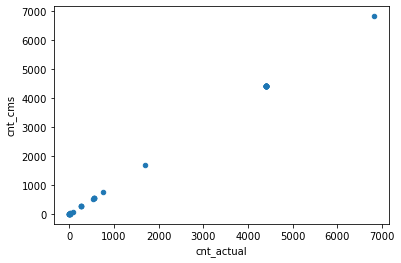

In [29]:
(
    counts_cms.to_frame('cnt_cms')
    .reset_index()
    .merge(
        counts_naive
        .to_frame('cnt_actual')
        .reset_index()
    ).set_index('index')
).plot.scatter(x='cnt_actual', y='cnt_cms')

In [35]:
df_diff = counts_naive.compare(counts_cms)
df_diff

,self,other


In [36]:
df_all = counts_naive.compare(counts_cms, keep_shape=True, keep_equal=True)
df_all

,self,other
and,6813,6813.0
a,4401,4401.0
a,4401,4401.0
a,4401,4401.0
a,4401,4401.0
with,1696,1696.0
an,755,755.0
or,558,558.0
or,558,558.0
have,529,529.0


In [37]:
diff_count = len(df_diff)
error_rate = diff_count / len(counts_naive)
print(f"Error rate is {error_rate}")

Error rate is 0.0


In [38]:
print(f"Total time naive: {time_naive_end - time_naive_start}s")
print(f"Total time cms: {time_cms_end - time_cms_start}s")

Total time naive: 0.1332089900970459s
Total time cms: 0.0021431446075439453s
